In [1]:
import numpy as np
import math
import itertools
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time
import networkx as nx

In [2]:
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
I = np.eye(2)

In [54]:
# produce all binary strings of length n with k 1s. If k is None then all possible binary strings of length n produced
def get_binary_strings(n, k=None):
    final = []
    def kbits(r):
        result = []
        for bits in itertools.combinations(range(n), r):
            s = ['0'] * n
            for bit in bits:
                s[bit] = '1'
            result.append(''.join(s))   
        return result

    if k != None:
        return kbits(k)
    
    for i in range(n + 1):
        final = final + kbits(i)
        
    return final


# lst is a list of pairs where pauli matrix is paired with ith qubit
def get_circuit_operators(nqubits, lst):
    temp = [I]*nqubits
    for i in range(len(lst)):
        temp[lst[i][1] - 1] = lst[i][0]
    
    ans = temp[0]
    
    for matrix in temp[1:]:
        ans = np.kron(ans, matrix)
    
    # returns for example X @ I @ I @ X @ I where @ is tensor product
    return ans


# coefficients don't matter, but gamma must not equal = (pi/2 + pi*k), (pi + pi*k), beta must not equal = pi/4
# if not coefficients will be lost
def generate_QAOA_operator(nqubits, locality, number_of_terms):
    # choosing both beta and gamma to have the same angle
    beta_angle = np.pi/10
    cos_angle = np.cos(beta_angle)
    sin_angle = np.sin(beta_angle)
    
    # get Z operators based on locality as binary strings and shuffle so as to pick the first "number of terms"
    # of the operators. As a result, the Hamiltonian/Operator/Instances are randomized
    Zs = get_binary_strings(nqubits, locality)
    random.shuffle(Zs)
    identity = np.eye(2**nqubits)
    
    
    ZiZjs = list()
    
    H = np.zeros((2**nqubits, 2**nqubits))
    
    # turn binary strings into matrices of ZiZj (based on locality)
    for i in range(number_of_terms):
        tempZ = list()
        for j in enumerate(Zs[i]):
            if j[1] == "1":
                tempZ.append((Z, j[0] + 1))
        
        ZiZjs.append(get_circuit_operators(nqubits, tempZ))
        
    for matrix in ZiZjs:
        H += matrix
    
    
    # Form unitary of mixer Hamiltonian
    unitary_x = identity
    
    temp_X_list = [[(X, i + 1)] for i in range(nqubits)]
    for Xi in temp_X_list:
        unitary_x  = unitary_x @ (cos_angle * identity -1j * sin_angle * get_circuit_operators(nqubits, Xi))
        
    unitary_x_ct = np.conj(unitary_x).T
    
    # Form unitary of cost Hamiltonian
    unitary_z = identity
    for i in ZiZjs:
        unitary_z = unitary_z @ (cos_angle *identity -1j * sin_angle * i)
        
    
    unitary_z_ct = np.conj(unitary_z).T
    
    # final operator in expected value
    ans = unitary_z_ct @ unitary_x_ct @ H @ unitary_x @ unitary_z
    

    if locality == 2:
        return ans, Zs[:number_of_terms]
        
    return ans


# only pauli strings containing X and I are considered
def get_pauli_coefficients(H):
    non_zero_pauli_strings = list()
    
    nonzero = 0
    
    # function kronecker_product_sequence returns matrix form of pauli strings of X and I using a binary string
    # where 0 is mapped to X and 1 to I. X->0, I->1
    # {X, I}^number of terms(n) to a 
    def kronecker_product_sequence(binary_string):
        lst = [X, I]
        ans = lst[int(binary_string[0])]
        
        for i in binary_string[1:]:
            ans = np.kron(ans, lst[int(i)])
            
        return ans
        
            
    hamiltonian_size = H.shape[0]
    n = int(math.log2(hamiltonian_size))
    bin_strings = get_binary_strings(n)
    
    for string in bin_strings:
        pauli_string = kronecker_product_sequence(string)
        coefficient = 1/H.shape[0] * np.trace(pauli_string@H) 
        
        if np.real(coefficient) > 1e-10 or np.imag(coefficient) > 1e-10:
            non_zero_pauli_strings.append((string, coefficient))
            nonzero += 1
       
    return nonzero, non_zero_pauli_strings


# with_graph set to true will draw graphs when locality is equal to 2 (a.k.a Max-cut)
def fill_locality_x_terms_grid(nqubits, with_graph=False, print_success_statement=True, avg_over=1):
    
    def generate_graph_for_locality2(Zs):
        nodes = [0]*nqubits
        edges = list()
        for string in Zs:
            temp_nodes = list()
            for bit in range(len(string)):
                if string[bit] == "1":
                    temp_nodes.append(bit)
            nodes[temp_nodes[0]] = 1
            nodes[temp_nodes[1]] = 1
            edges.append((temp_nodes[0], temp_nodes[1]))

        nodes = [i for i in range(len(nodes)) if nodes[i] == 1]
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        
        if with_graph:
            pos = nx.spiral_layout(G)
            fig, ax = plt.subplots()
            fig.set_figwidth(3)
            fig.set_figheight(3)
            nx.draw_networkx(G, ax=ax, labels={n: n for n in G})
        
        return G
    
    
    # for a triangle with nodes 1,2,3 - X1X2, X2X3, X1X3 will be generated and Xs on all isolated nodes
    def check_count_of_strings_locality2(G):
        triangles = set()
        edges = list(G.edges())
        edges = [edge if edge[0] < edge[1] else (edge[1], edge[0]) for edge in edges]
        
        for i in range(0, len(edges) - 1):
            for j in range(i + 1, len(edges)):
                e1 = edges[i]
                e2 = edges[j]
                if e1[0] == e2[0]:
                    if (e1[1], e2[1]) in edges:
                        triangles.add((e1[0], e1[1], e2[1]))
                    elif (e2[1], e1[1]) in edges:
                        triangles.add((e1[0], e2[1], e1[1]))
                else:
                    break
                    
        triangle_strings = set()
        
        for triangle in triangles:
            triangle_strings.add(str(triangle[0]) + str(triangle[1]))
            triangle_strings.add(str(triangle[1]) + str(triangle[2]))
            triangle_strings.add(str(triangle[0]) + str(triangle[2]))
            
        
        
        number_of_non_isolated_vertices = 0
        
        for node in list(G.nodes):
            if G.degree[node] > 0:
                number_of_non_isolated_vertices += 1
        
        return number_of_non_isolated_vertices + len(triangle_strings)        
        
        
    start = time.time()
    hamiltonian_pauli_strings = list()
    number_of_terms = range(1, nqubits + 1)
    locality = range(1, nqubits + 1)
    
    # grid has shape locality by number of terms
    rows, cols = (locality[-1], number_of_terms[-1]) 
    number_of_non_zero_coefficients = [[0 for i in range(cols)] for j in range(rows)] 
    
    
    for ith_instance in range(avg_over):
        for i in locality:
            temp_list = list()
            pauli_temp_list = list()

            all_good = True
            for j in number_of_terms:
                if i == nqubits and j > 1:
                    temp_list.append(0)
                    continue

                H = generate_QAOA_operator(nqubits, i, j)
                non_zero, string = get_pauli_coefficients(H[0]) if i == 2 else get_pauli_coefficients(H)

                # check if counting is same as code
                if i == 2:
                    G = generate_graph_for_locality2(H[1])
                    count = check_count_of_strings_locality2(G)
                    if  count != non_zero:
                        all_good = False

                temp_list.append(non_zero)
                pauli_temp_list.append(string)

            if i == 2 and print_success_statement:
                if all_good:
                    print("\033[92m {}\033[00m".format("At this juncture counting has made a consensus with this code."\
                            "By the power invested in me by the Great Akshay,"\
                            "I declare this a point where the theory meets with the practical"))
                    print("\033[91m {}\033[00m".format("NOTE: Check is done for locality 2. "\
                            "Along with Akshay we shall pull the sword out of the stone as King Arthur did"))
                else:
                    print("Damn thy are not worthy")
                    print(count)
            
            for index in range(len(number_of_non_zero_coefficients[i - 1])):
                number_of_non_zero_coefficients[i - 1][index] += temp_list[index]
            
            if avg_over == 1:
                hamiltonian_pauli_strings.append(pauli_temp_list)
#             number_of_non_zero_coefficients.append(temp_list)
#             hamiltonian_pauli_strings.append(pauli_temp_list)

        end = time.time()
    
        if print_success_statement:
            print("Time for {}qubits: {}".format(nqubits, end-start))
            
    for loc in range(len(number_of_non_zero_coefficients)):
        for no_term in range(len(number_of_non_zero_coefficients[loc])):
            number_of_non_zero_coefficients[loc][no_term] /= avg_over

    if avg_over > 1:
        return number_of_non_zero_coefficients, all_good
    
    return number_of_non_zero_coefficients, hamiltonian_pauli_strings, all_good


def test(start=1, stop=7, seeds=10):
    no_error = True
    for i in range(seeds):
        if not no_error:
            print("ERROR")
            return
        for qubit in range(start, stop + 1):
            qubitn, qubitn_pauli, is_goodn = fill_locality_x_terms_grid(qubit, print_success_statement=False)
            if not is_goodn:
                no_error = False
                break
    
    print("ALL GOOD")

    
def plot_grid(grid):

    localities = [i + 1 for i in range(len(grid))]
    num_of_terms = [i + 1 for i in range(len(grid[0]))]


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(grid, interpolation='nearest', cmap='cool')
    fig.colorbar(cax)

    ax.set_xticklabels(['']+localities)
    ax.set_yticklabels(['']+num_of_terms)
    
    for index, locality in enumerate(grid):
        for number_of_terms in range(len(locality)):
            ax.text(number_of_terms, index, str(grid[index][number_of_terms]),  ha='center', va='center')
            
    ax.set_xlabel('No. of Terms', fontsize = 15)
    ax.set_ylabel('Locality', fontsize = 15)
    ax.set_title(str(len(localities)) + " Qubits", fontsize = 20)

    plt.show()

In [55]:
test()

ALL GOOD


In [64]:
avgqubit2, avgis_good2 = fill_locality_x_terms_grid(2, print_success_statement=False, avg_over=10)

In [65]:
avgqubit3, avgis_good3 = fill_locality_x_terms_grid(3, print_success_statement=False, avg_over=10)

In [79]:
avgqubit4, avgis_good4 = fill_locality_x_terms_grid(4, print_success_statement=False, avg_over=10)

In [67]:
avgqubit5, avgis_good5 = fill_locality_x_terms_grid(5, print_success_statement=False, avg_over=10)

In [80]:
avgqubit6, avgis_good6 = fill_locality_x_terms_grid(6, print_success_statement=False, avg_over=10)

In [69]:
avgqubit7, avgis_good7 = fill_locality_x_terms_grid(7, print_success_statement=False, avg_over=10)

In [77]:
avgqubit8, avgis_good8 = fill_locality_x_terms_grid(8, print_success_statement=False, avg_over=10)

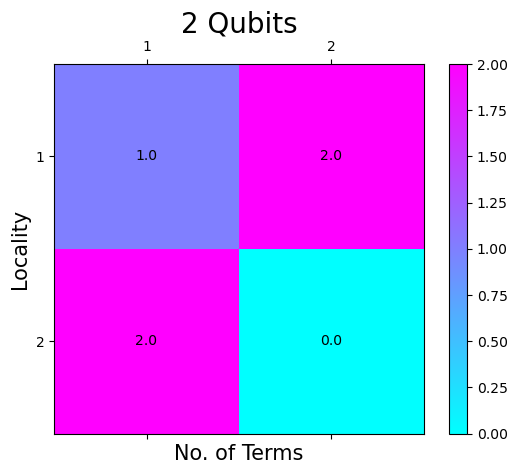

In [71]:
plot_grid(avgqubit2)

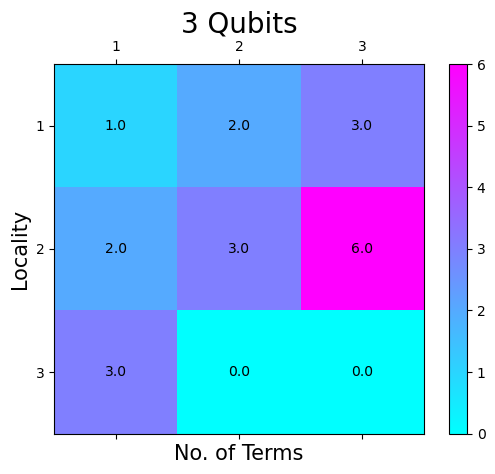

In [72]:
plot_grid(avgqubit3)

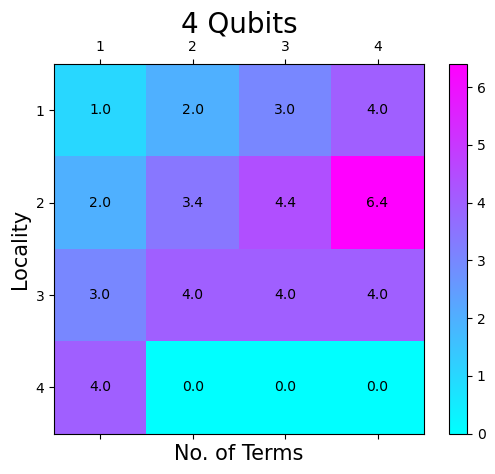

In [73]:
plot_grid(avgqubit4)

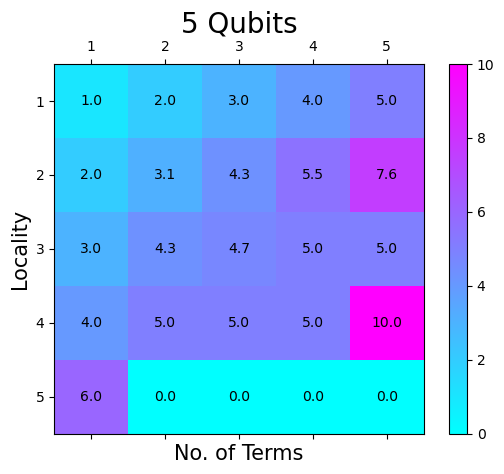

In [74]:
plot_grid(avgqubit5)

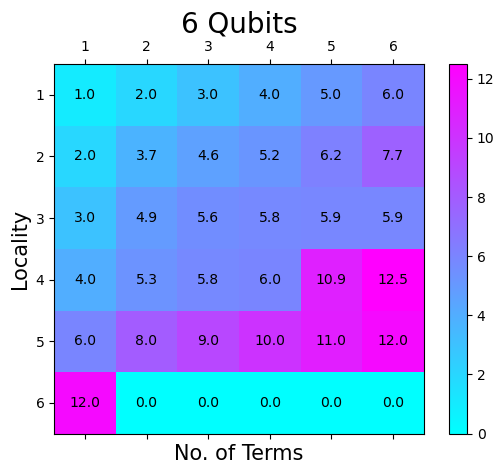

In [81]:
plot_grid(avgqubit6)

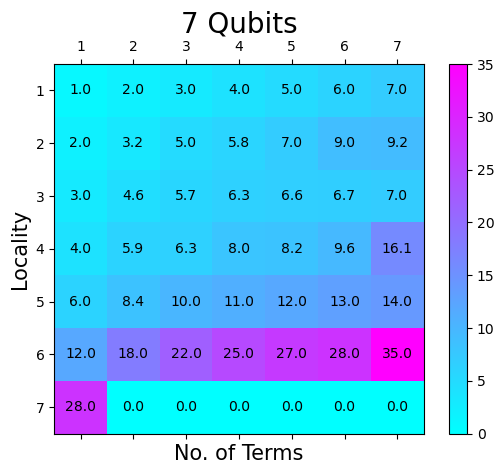

In [76]:
plot_grid(avgqubit7)

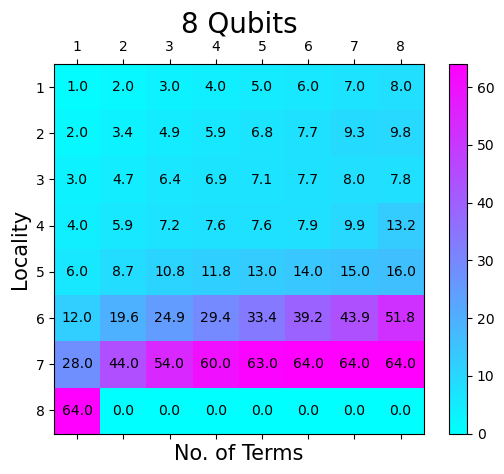

In [78]:
plot_grid(avgqubit8)

In [ ]:
qubit2, qubit2_pauli, is_good2 = fill_locality_x_terms_grid(2)
qubit3, qubit3_pauli, is_good3 = fill_locality_x_terms_grid(3)
qubit4, qubit4_pauli, is_good4 = fill_locality_x_terms_grid(4)
qubit5, qubit5_pauli, is_good5 = fill_locality_x_terms_grid(5)
qubit6, qubit6_pauli, is_good6 = fill_locality_x_terms_grid(6)
qubit7, qubit7_pauli, is_good7 = fill_locality_x_terms_grid(7)
qubit8, qubit8_pauli, is_good8 = fill_locality_x_terms_grid(8)

In [ ]:
plot_grid(qubit2)

In [ ]:
plot_grid(qubit3)

In [ ]:
plot_grid(qubit4)

In [ ]:
plot_grid(qubit5)

In [ ]:
plot_grid(qubit6)

In [ ]:
plot_grid(qubit7)

In [ ]:
plot_grid(qubit8)